In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2
import torch.nn as nn
import torch

#img1 = cv2.imread('donald-trump-1.jpg')
#img2 = cv2.imread('donald-trump-2.jpg')

#data  cis.upenn.edu/~cis580/Spring2015/Projects/proj2/SfMProjectData.zip

img1 = cv2.imread('image0000001.bmp')
img2 = cv2.imread('image0000002.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=2)

plt.imshow(img3)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
pts1 = cv2.KeyPoint_convert(kp1)
pts2 = cv2.KeyPoint_convert(kp2)
print(dir(matches[0]))
print(matches[0].trainIdx)
print(matches[0].queryIdx)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
395
371


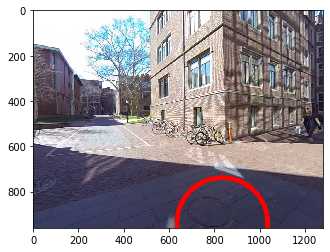

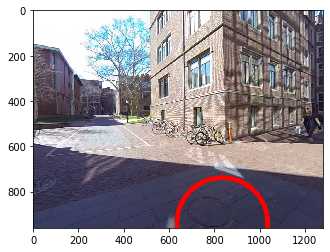

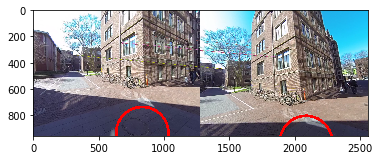

[[1194.3939     17.418243]]
[[369.10086 379.46884]]


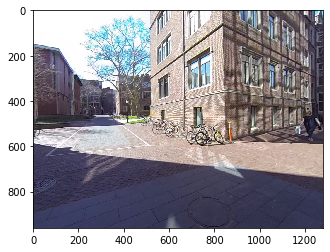

In [3]:
imageA = img1.copy()
imageB = img2.copy()
imageA = cv2.circle(imageA , (835, 938), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
imageB = cv2.circle(imageB , (806, 1006), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
img4 = cv2.drawMatches(imageA, kp1, imageB, kp2, matches[:10], None, flags=2)
plt.imshow(img4)
plt.show()
print(cv2.KeyPoint_convert([kp1[matches[0].trainIdx]]))
print(cv2.KeyPoint_convert([kp2[matches[0].queryIdx]]))

plt.imshow(img1)
plt.show()

In [4]:
import random
import scipy.linalg

#Normalized 8-point algorithm

class LinearLeastSquaresModel():
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.

    """

    def __init__(self, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device    
        self.MSE = nn.MSELoss(reduction='none')
        #value will be assigned after calling fit
        self.x = None
        
    def fit(self, data, T1, T2):
        _, _, Vh = scipy.linalg.svd(data)
        #(Hermitian) transpose back
        x = Vh.transpose()[:, -1];
        U, D, Vh = scipy.linalg.svd(x.reshape((3, 3)))
        F = U @ np.diag(np.array([D[1], D[2], 0])) @ Vh
        F = T2.transpose() @ F @ T1
        self.x = torch.tensor(F).view(9).to(self.device);
        return F
    
    def calc_err(self, data):
        batch_size = data.shape[0]
        compute_result = (data @ self.x)
        err = self.MSE(compute_result, torch.zeros((batch_size), dtype=torch.float64).to(self.device))
        return err

def EstimateFundamentalMatrix(sample_points, T1, T2, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    LSmodel = LinearLeastSquaresModel(device = device)
    F = LSmodel.fit(np.array(sample_points), T1, T2)
 
    return F, LSmodel    
    


def convert2Homogeneous(a):
    temp = np.zeros((3,len(a)))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        temp[0][i] = x1
        temp[1][i] = y1
        temp[2][i] = 1
    return temp

def normalise2dpts(pts):
    """
    based on http://pydoc.net/ippe/0.0.1/ippe.homo2d/
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));
    
    if len(finiteind) != pts.shape[1]:
        print('WARNING(normalise2dpts): Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;

        c = np.mean(pts[0:2,i].T, axis=0).T          

        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
    
        dist.append(np.sqrt(newp1**2 + newp2**2))

    meandist = np.mean(dist[:])
    
    scale = np.sqrt(2)/meandist
    
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    
    newpts = T.dot(pts)
    return [newpts, T]

def transform(a,b):
    #####
    #input shape: [batch, [x, y, 1]]
    #return: list 
    #        shape: [batch, [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]]
    #####
    mat = []
    assert(len(a)==len(b))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        x2 = b[i][0]
        y2 = b[i][1]
        mat.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return mat

    
def RANSAC(trainPoints, queryPoints, max_iter_times = 1000000, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    t = time.time()
    x1, T1 = normalise2dpts(convert2Homogeneous(trainPoints))
    x2, T2 = normalise2dpts(convert2Homogeneous(queryPoints))
    data = transform(x1.transpose(), x2.transpose())
    
    iterations = 0
    batches = torch.tensor(data, dtype=torch.float64).to(device)
    
    batch_size = batches.shape[0]
    
    episilon = batches.new_full((1, batch_size), 0.01).view(batch_size).to(device)
    train_inliers = []
    query_inliers = []
    
    while iterations < max_iter_times:

        sample_points = random.sample(data, 8)
        F, LSmodel = EstimateFundamentalMatrix(sample_points, T1, T2, device)
        err = LSmodel.calc_err(batches)
        if((err < episilon).float().mean().item() > 0.95):           
            ind = np.where((err.cpu()<episilon.cpu()))
            train_inliers = trainPoints[ind]
            query_inliers = queryPoints[ind]
            break
        iterations += 1
        
    print('[RANSAC] takes ', time.time() - t,'sec')
    print('[RANSAC] iteration', iterations,' err:', err.mean().item())     
    if(iterations == max_iter_times):
        print("no result found by RANSAC")
    
    return F, train_inliers, query_inliers, ind

In [5]:
trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
F, train_inliers, query_inliers, ind = RANSAC(trainPoints, queryPoints, max_iter_times = 1000000)
print('F',F)
F, mask = cv2.findFundamentalMat(trainPoints,queryPoints,cv2.FM_LMEDS)
print('opencv_F',F)

WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.02736639976501465 sec
[RANSAC] iteration 3  err: 0.003639029783622952
F [[-8.90462313e-07  3.08308929e-06 -3.27639382e-04]
 [ 1.04956395e-06 -2.37243180e-06  5.50117203e-05]
 [-1.12137488e-04  1.29603633e-06  6.03231617e-02]]
opencv_F [[-5.03773825e-07 -1.04895552e-07  3.68371907e-04]
 [ 2.25260921e-06  2.05999542e-06 -2.39201885e-03]
 [-7.46550999e-04 -1.12537940e-03  1.00000000e+00]]


In [6]:
print(np.array(train_inliers).shape)


(178, 2)


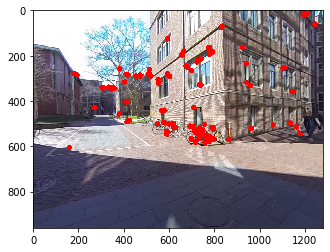

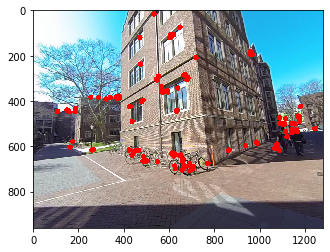

In [7]:
imageA = img1.copy()
imageB = img2.copy()
for i in train_inliers:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in query_inliers:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageB)
plt.show()


In [8]:
f1 = 568.996140852
f2 = 568.988362396
s = 0
mx = my = 1
px = 643.21055941
py = 477.982801038
K = np.array([[f1*mx, s, px],[0, f2*my, py], [0, 0, 1]])
E = K.transpose() @ F @ K

In [9]:
print('Fundamental Matrix:',F)
print('Camera intrinsic Matrix:',K)
print('Essential Matrix:',E)

Fundamental Matrix: [[-5.03773825e-07 -1.04895552e-07  3.68371907e-04]
 [ 2.25260921e-06  2.05999542e-06 -2.39201885e-03]
 [-7.46550999e-04 -1.12537940e-03  1.00000000e+00]]
Camera intrinsic Matrix: [[568.99614085   0.         643.21055941]
 [  0.         568.9883624  477.98280104]
 [  0.           0.           1.        ]]
Essential Matrix: [[-0.16310011 -0.03396016 -0.00329961]
 [ 0.72928715  0.66691889  0.02362756]
 [ 0.003485   -0.11846733 -0.00198296]]


In [10]:
U, D, Vh = scipy.linalg.svd(E)
print('U:',U)
print('D:',D)
print('Vh:',Vh)
W = np.array([[0, -1, 0],[1, 0 ,0], [0, 0, 1]])
print('W',W)
eps = 1e-5
def CameraPosition1Config():
    R1 = U @ W @ Vh
    C1 = U[:,2]
    det = np.linalg.det(R1)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C1 = -C1
        R1 = -R1 
    return C1, R1

def CameraPosition2Config():
    R2 = U @ W @ Vh
    C2 = -U[:,2]
    det = np.linalg.det(R2)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C2 = -C2
        R2 = -R2    
    return C2, R2

def CameraPosition3Config():
    R3 = U @ W.transpose() @ Vh
    C3 = U[:,2]
    det = np.linalg.det(R3)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C3 = -C3
        R3 = -R3
    return C3, R3    
        
def CameraPosition4Config():
    R4 = U @ W.transpose() @ Vh
    C4 = -U[:,2]
    det = np.linalg.det(R4)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C4 = -C4
        R4 = -R4
    return C4, R4

U: [[-0.14349556 -0.68202768  0.71711036]
 [ 0.98666803 -0.04237576  0.15713208]
 [-0.07678033  0.73009763  0.67901564]]
D: [1.00187680e+00 1.23523685e-01 9.76108716e-10]
Vh: [[ 0.74130959  0.6707378   0.02389345]
 [ 0.67095697 -0.74149455 -0.00160749]
 [-0.01663866 -0.01722312  0.99971322]]
W [[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]


In [11]:
def CameraPoseMatrix(K, R, C):
    return K @ R @ np.array([[1,0,0, -C[0]],[0,1,0, -C[1]],[0,0,1, -C[2]]])

In [12]:
#first camera
C0 = np.array([0,0,0])
R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])
P1 = CameraPoseMatrix(K, R0, C0)#K @ R0 @ np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])


#second camera
C1, R1 = CameraPosition1Config()
C2, R2 = CameraPosition2Config()
C3, R3 = CameraPosition3Config()
C4, R4 = CameraPosition4Config()
E = U @ np.array([[1,0,0],[0,1,0],[0,0,0]]) @ Vh
P2 = CameraPoseMatrix(K, R1, C1) #np.concatenate((R1, -C1.reshape(3,1)), axis=1)
print('P1:', P1)
print('P2:', P2)
print('R1:', R1)
print('C1:', C1)

P1: [[568.99614085   0.         643.21055941   0.        ]
 [  0.         568.9883624  477.98280104   0.        ]
 [  0.           0.           1.           0.        ]]
P2: [[-1.34305313e+02  5.70221870e+01 -8.46278314e+02 -6.61987926e+02]
 [ 1.18117004e+02 -5.99832377e+02 -4.22450953e+02 -2.96400786e+02]
 [-5.81446759e-01 -4.21077111e-01 -6.96142035e-01 -9.55817547e-01]]
R1: [[ 0.42124606  0.5762138  -0.70037805]
 [ 0.69603981 -0.70047963 -0.15766058]
 [-0.58144676 -0.42107711 -0.69614204]]
C1: [-0.71711036 -0.15713208 -0.67901564]


In [13]:
from numpy.linalg import inv
print(C1)
print(R1)
print(img1.shape)

[-0.71711036 -0.15713208 -0.67901564]
[[ 0.42124606  0.5762138  -0.70037805]
 [ 0.69603981 -0.70047963 -0.15766058]
 [-0.58144676 -0.42107711 -0.69614204]]
(960, 1280, 3)


In [14]:
from scipy.linalg import lstsq
from scipy.optimize import lsq_linear

def LinearTriangulation(v1, v2, P1, P2):
    row1 = v1[0]*P1[2,:] - P1[1,:]
    row2 = v1[1]*P1[2,:] - P1[0,:]
    row3 = v2[0]*P2[2,:] - P2[1,:]
    row4 = v2[1]*P2[2,:] - P2[0,:]
    #row5 = np.array([1,1,1,1])
    A = np.array([row1,row2,row3,row4])
    b = np.array([0,0,0,0])
    res = lsq_linear(A, b, bounds=([-1000,-1000,-1000,1], [1000,1000,1000,1.0001]),lsmr_tol='auto')
    return res.x

In [15]:
def getWorldPoints(train_inliers, query_inliers, P1, P2):
    points = []
    for (train_inlier, query_inlier) in zip(train_inliers, query_inliers):
        points.append(LinearTriangulation(train_inlier, query_inlier, P1, P2))
    return np.array(points)

In [16]:
points = getWorldPoints(train_inliers, query_inliers, P1, P2)


In [17]:
print(points[:10])

[[ 0.10928738  0.08574437 -0.12022697  1.        ]
 [ 0.25229954  0.54987233 -0.73806429  1.        ]
 [-0.69796556  0.55688326  0.22385797  1.        ]
 [ 0.05673793  0.12933869 -0.21010146  1.        ]
 [ 0.05933101  0.00943596 -0.13772732  1.        ]
 [-0.05624679  0.22274332 -0.48100609  1.        ]
 [-0.45784377  0.12514245 -0.32020953  1.        ]
 [-0.03186055  0.19045203 -0.24681483  1.        ]
 [-0.48968542  0.1340557  -0.26417853  1.        ]
 [-0.0292621   0.15274072  0.07974175  1.        ]]


In [18]:
print(len(points))

178


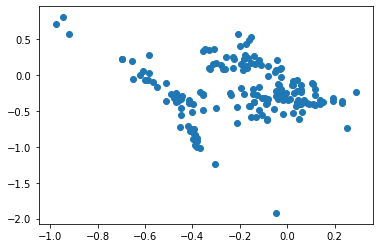

In [19]:
import matplotlib.pyplot as plt
#XZ
plt.scatter(points[:,0], points[:,2])
plt.show()


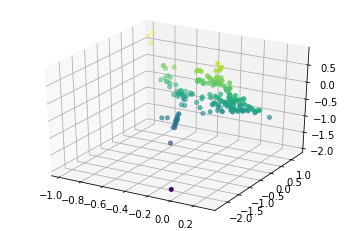

In [20]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);

In [21]:
# def sift_feature(image, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
#     print("image shape:",image.shape, )
#     h,w = image.shape
#     patch_size = min([h,w])
#     patch = image[:patch_size, :patch_size]#image[h//4: h//4 + patch_size,w//3 : w//3 + patch_size]
#     # It takes n_patches x 1 x patch_size x patch_size input == standard pytorch batch format
#     patches = np.ndarray((1, 1, patch_size, patch_size), dtype=np.float32)
#     patches[0,0,:,:] = patch
        
#     SIFT = SIFTNet(patch_size = patch_size).to(device)
#     SIFT.eval()
    
#     t = time.time()
#     with torch.no_grad():       
#         torch_patches = torch.from_numpy(patches).cuda()
#         res = SIFT(torch_patches)
#         print(res)
#         sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)

#     print ('device:',device)
#     print(' time', time.time() - t)   
#     plt.figure()
#     plt.imshow(patch, cmap="gray")
#     return sift

In [65]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2
import glob, os
from mpl_toolkits import mplot3d

from Normalized8pointsAlgo import RANSAC
from CameraConfig import *
from Triangulation import *


def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    (r,c,_) = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


def TwoImage(img1, img2, des1, kp1, des2, kp2, pre_C, pre_R):
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
    queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
    pts1 = np.int32(trainPoints)
    pts2 = np.int32(queryPoints)
    
    my_F, train_inliers, query_inliers, ind = RANSAC(pts1, pts2, max_iter_times = 1000000) 

    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(query_inliers.reshape(-1,1,2), 2, my_F)
    lines1 = lines1.reshape(-1,3)
    left_img_with_lines, _ = drawlines(img1.copy(),img2.copy(),lines1,train_inliers,query_inliers)
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(train_inliers.reshape(-1,1,2), 1, my_F)
    lines2 = lines2.reshape(-1,3)
    right_img_with_lines, _ = drawlines(img2.copy(),img1.copy(),lines2,query_inliers,train_inliers)

    

    E = getEssentialMatrix(my_F)
    U, D, Vh = getEssentialConfig(E)

    #second camera
    #C, R are relative to pre camera at [0,0,0]
    C1, R1 = CameraPosition1Config(U, D, Vh)
    C2, R2 = CameraPosition2Config(U, D, Vh)
    C3, R3 = CameraPosition3Config(U, D, Vh)
    C4, R4 = CameraPosition4Config(U, D, Vh)
    
    Cs = [C1,C2,C3,C4]
    Rs = [R1,R2,R3,R4]
    
    #relative to previous camera at exactly position
    for C, R in zip(Cs, Rs):
        R = R @ pre_R.transpose()
        C += -R @ pre_C 
        
    best_ct = 0
    best_secondCamera_C = None
    best_secondCamera_R = None
    points = None

    for C,R in zip(Cs, Rs):
        P1, P2 = getCameraMatrix(K, pre_R, pre_C, R, C) 
        temp_points = getWorldPoints(train_inliers, query_inliers, P1, P2)
        n_in_front_of_C1, n_in_front_of_C2 = CheckCheirality(temp_points, C1, R1, C2, R2)
        if(n_in_front_of_C1 + n_in_front_of_C2 > best_ct):
            best_ct = n_in_front_of_C1 + n_in_front_of_C2
            best_secondCamera_C = C
            best_secondCamera_R = R
            points = temp_points
    #print("max points in front of both cameras:", best_ct)
    print("len(points):",len(points))
##########draw############    
#     #XZ
#     plt.scatter(points[:,0], points[:,2])
#     plt.scatter(pre_C[0], pre_C[2], c='red')
#     plt.scatter(best_secondCamera_C[0], best_secondCamera_C[2], c='black')
#     plt.show()
#     ax = plt.axes(projection='3d')
    
#     ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);
#     ax.scatter(pre_C[0], pre_C[1], pre_C[2], c='red', linewidth=15);
#     ax.scatter(best_secondCamera_C[0], best_secondCamera_C[1], best_secondCamera_C[2], c='black', linewidth=15);
#     plt.show()
#########################    
    return [left_img_with_lines, right_img_with_lines],best_secondCamera_C, best_secondCamera_R, K.astype(np.float64), train_inliers.astype(np.float64), query_inliers.astype(np.float64), points.astype(np.float64)
    
if __name__== "__main__":
    files = []
    for file in glob.glob("*.bmp"):
        print(file)
        files.append(file)
    files.sort()
    
    imgs = []
    
    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    camera_params = []
    camera_indices = []
    points_3d = []
    points_2d = []
 
    C = {}
    R = {}
    pre_img = None
    pre_kp = None
    pre_des = None
    dist_coef = np.zeros((4,1))
    
    lines_imgs = []
    
    for img_ct, img in tqdm(enumerate(imgs)):
        print(img_ct)
        if(img_ct == 0):
            orb = cv2.ORB_create(edgeThreshold=3)
            pre_img = img
            pre_kp, pre_des = orb.detectAndCompute(pre_img,None)
            #first camera
            pre_C = np.array([0,0,0], dtype=np.float64)
            pre_R = np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=np.float64)
            C[img_ct] = pre_C
            R[img_ct] = pre_R
            continue;
        else:
            #Oriented FAST and Rotated BRIEF
            orb = cv2.ORB_create(edgeThreshold=3)

            # find the keypoints with ORB
            kp, des = orb.detectAndCompute(img,None)
            
            lines_img, outC, outR, K, train_inliers, query_inliers, points3D = TwoImage(imgs[img_ct-1], img, pre_des, pre_kp, des, kp, C[img_ct-1] ,R[img_ct-1])
            lines_imgs.append(lines_img)
            #the first image hasn't been count
            if(img_ct == 1):
                #add the first image rvec and tvec
                #(_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], train_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)            
                tvec = C[0]
                rvec, jacobian = cv2.Rodrigues(R[0])
                print(tvec)
                print(rvec)
                camera_params.append([rvec[0][0], rvec[1][0], rvec[2][0], tvec[0], tvec[1], tvec[2], f1, 0, 0])
                for i in range(len(points3D)):
                    points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
                    camera_indices.append(0)
                for i in range(len(train_inliers)):
                     points_2d.append(train_inliers[i]) 
            
            tvec = outC
            rvec, jacobian = cv2.Rodrigues(outR)
            #(_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], query_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
            camera_params.append([rvec[0][0], rvec[1][0], rvec[2][0], tvec[0], tvec[1], tvec[2], f1, 0, 0])
            for i in range(len(points3D)):
                points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
                camera_indices.append(img_ct)              
            for i in range(len(query_inliers)):
                points_2d.append(query_inliers[i])    
            
            pre_img = img
            pre_kp = kp
            pre_des = des
            C[img_ct] = outC
            R[img_ct] = outR
            
    
    #table = []
    
#     for img1_ct,img1 in enumerate(files):
#         for i 2_ct,img2 in enumerate(files):
#             if img1 != img2 and img1_ct < img2_ct:
#                 print(img1_ct, img2_ct, img1, img2)
#                 dist_coef = np.zeros((4,1))
#                 outC, outR, K, train_inliers, query_inliers, points3D = TwoImage(img1,img2, C[img1_ct], R[img1_ct])
#                 if img1_ct == 0:
#                     C[img2_ct] = outC
#                     R[img2_ct] = outR
#                 print(len(train_inliers))
#                 print(len(points3D))
#                 try:
#                     (_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], train_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
#                 except:
#                     if(img1_ct==0):
#                         raise
#                     else:
#                         continue
#                 camera_params.append([rvec[0].item(), rvec[1].item(), rvec[2].item(), tvec[0].item(), tvec[1].item(), tvec[2].item(), f1, 0, 0])
#                 for i in range(len(points3D)):
#                     points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
#                     camera_indices.append(img1_ct)
                    
#                 for i in range(len(train_inliers)):
#                     points_2d.append(train_inliers[i]) 
                
                
#                 try:
#                     (_, rvec, tvec, _) = cv2.solvePnPRansac(points3D[:,0:3], query_inliers, K, dist_coef, cv2.SOLVEPNP_EPNP)
#                 except:
#                     continue
#                 camera_params.append([rvec[0].item(), rvec[1].item(), rvec[2].item(), tvec[0].item(), tvec[1].item(), tvec[2].item(), f1, 0, 0])
#                 for i in range(len(points3D)):
#                     points_3d.append([points3D[i,0], points3D[i,1], points3D[i,2]])
#                     camera_indices.append(img2_ct)
#                 for i in range(len(query_inliers)):
#                     points_2d.append(query_inliers[i])
                
#                 #table.append({str(img1_ct)+"to"+str(img2_ct):[rvec,tvec]})
#                 #solvePnP(InputArray objectPoints, InputArray imagePoints, InputArray cameraMatrix, InputArray distCoeffs, OutputArray rvec, OutputArray tvec, bool useExtrinsicGuess=false, int flags=ITERATIVE )¶

0it [00:00, ?it/s]

image0000005.bmp
image0000006.bmp
image0000004.bmp
image0000002.bmp
image0000001.bmp
image0000003.bmp
0
1
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.22675514221191406 sec
[RANSAC] iteration 630  err: 6.73050662716908e-07
this is E
[[-0.00581634  0.00804406  0.00211918]
 [-0.00230273  0.01576522  0.00354536]
 [ 0.00097615  0.00547607  0.00111279]]
this is D
[1.95014393e-02 4.61674270e-03 1.37628180e-18]


2it [00:01,  1.90it/s]

len(points): 178
[0. 0. 0.]
[[0.]
 [0.]
 [0.]]
2
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.02609419822692871 sec
[RANSAC] iteration 68  err: 2.9081512852048364e-06
this is E
[[-0.06956817 -0.20239388 -0.05549997]
 [ 0.01950483  0.2617967   0.0978126 ]
 [-0.03645316 -0.09330797 -0.02396923]]
this is D
[3.68036096e-01 5.02760138e-02 2.81867374e-17]


3it [00:01,  1.55it/s]

len(points): 200
3
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.0962839126586914 sec
[RANSAC] iteration 287  err: 5.775274583477284e-06
this is E
[[-0.09207847  0.08659664 -0.00158746]
 [ 0.00402392  0.06777212 -0.01150811]
 [-0.01522122  0.04923435 -0.00591219]]
this is D
[1.43569603e-01 5.29155902e-02 1.75412196e-17]


4it [00:02,  1.33it/s]

len(points): 200
4
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.09126877784729004 sec
[RANSAC] iteration 275  err: 2.7637819159316493e-06
this is E
[[-0.0572441   0.08570564  0.06585638]
 [-0.02742981  0.1336009   0.07610744]
 [-0.05076387  0.04361228  0.04280619]]
this is D
[2.08876349e-01 4.51152673e-02 6.58724633e-18]


5it [00:03,  1.20it/s]

len(points): 209
5
WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  0.012789487838745117 sec
[RANSAC] iteration 26  err: 2.0938570818088276e-06
this is E
[[-0.01226945 -0.00709077  0.01470692]
 [ 0.23102135 -0.40341245 -0.13236736]
 [-0.05484323  0.11252574  0.02691182]]
this is D
[4.99912943e-01 2.30611555e-02 1.44915465e-17]


6it [00:04,  1.18it/s]

len(points): 190


In [66]:
print(points_3d[:10])

[[0.4596289390685335, -1.0231857798238906, -0.5686128140532936], [-0.05339173802298704, -0.40591580811247646, 0.6614911043801577], [-0.8330381035084071, 0.7072927764192898, 1.0813560203863013], [0.17710154195699868, -0.4031713916794088, 0.029813484438544004], [0.14007255456222567, -0.29628206552729996, 0.08512663345100321], [-0.051112722423503225, -0.09783163355744459, 1.120463544554092], [-0.7533489360191984, 0.14648203923272315, 1.2515426215202972], [-0.29844015052778167, 0.14810546330349297, 1.0116045337868298], [-0.7741807463338485, 0.10797155808343747, 1.2577550844515835], [0.7327409380622625, -1.054262021306011, -2.0093643907483596]]


1155
n_cameras: 6
n_points: 1155
Total number of parameters: 3519
Total number of residuals: 2310
[  0.           0.           0.           0.           0.
   0.         568.99614085   0.           0.        ]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7661e+10                                    9.87e+19    
       1              2         4.4170e+09      1.32e+10       2.97e+02       2.31e+18    
       2              4         2.3906e+09      2.03e+09       1.38e+02       5.86e+17    
       3              6         1.7227e+09      6.68e+08       5.31e+01       2.68e+17    
       4              7         8.7792e+08      8.45e+08       1.01e+02       5.56e+16    
       5              8         2.1182e+08      6.66e+08       2.01e+02       1.95e+15    
       6             10         1.1813e+08      9.37e+07       1.12e+02       6.43e+14    
       7             12         8.1327e+07      3.68e+07      

      91             123        4.4765e+02      5.00e-02       9.00e-04       1.92e+13    
      92             124        4.4736e+02      2.90e-01       3.48e-04       1.65e+13    
      93             125        4.4720e+02      1.60e-01       3.33e-04       1.58e+13    
      94             126        4.4706e+02      1.35e-01       4.40e-04       1.51e+13    
      95             127        4.4693e+02      1.29e-01       4.37e-04       1.51e+13    
      96             128        4.4680e+02      1.30e-01       4.32e-04       1.46e+13    
      97             129        4.4666e+02      1.49e-01       4.16e-04       1.46e+13    
      98             130        4.4653e+02      1.25e-01       4.21e-04       1.41e+13    
      99             131        4.4638e+02      1.46e-01       4.16e-04       1.40e+13    
      100            132        4.4616e+02      2.20e-01       8.13e-04       1.38e+13    
      101            133        4.4568e+02      4.87e-01       1.60e-03       1.39e+13    

      184            225        4.2652e+02      2.09e-01       7.98e-04       1.72e+13    
      185            226        4.2628e+02      2.45e-01       8.04e-04       1.69e+13    
      186            227        4.2580e+02      4.78e-01       1.56e-03       1.66e+13    
      187            228        4.2565e+02      1.48e-01       3.22e-03       1.93e+13    
      188            229        4.2476e+02      8.92e-01       8.99e-04       1.68e+13    
      189            230        4.2470e+02      6.05e-02       1.77e-03       2.01e+13    
      190            231        4.2453e+02      1.72e-01       5.02e-04       1.93e+13    
      191            232        4.2435e+02      1.74e-01       5.68e-04       1.86e+13    
      192            233        4.2422e+02      1.31e-01       4.55e-04       1.84e+13    
      193            234        4.2405e+02      1.71e-01       4.33e-04       1.78e+13    
      194            235        4.2389e+02      1.62e-01       4.12e-04       1.74e+13    

      278            328        4.0442e+02      1.02e-01       4.56e-04       1.52e+13    
      279            329        4.0430e+02      1.28e-01       4.09e-04       1.54e+13    
      280            330        4.0417e+02      1.29e-01       3.96e-04       1.47e+13    
      281            331        4.0404e+02      1.24e-01       4.05e-04       1.49e+13    
      282            332        4.0391e+02      1.29e-01       3.97e-04       1.42e+13    
      283            333        4.0369e+02      2.29e-01       7.90e-04       1.45e+13    
      284            334        4.0323e+02      4.51e-01       1.56e-03       1.41e+13    
      285            335        4.0241e+02      8.23e-01       3.01e-03       1.48e+13    
      286            336        4.0064e+02      1.77e+00       5.95e-03       1.45e+13    
      287            339        4.0046e+02      1.83e-01       7.12e-04       1.53e+13    
      288            340        4.0044e+02      1.82e-02       1.67e-03       1.69e+13    

      371            433        3.8255e+02      7.82e-01       3.10e-03       1.55e+13    
      372            435        3.8248e+02      6.43e-02       1.62e-03       1.73e+13    
      373            436        3.8213e+02      3.57e-01       6.56e-04       1.57e+13    
      374            437        3.8189e+02      2.36e-01       4.19e-04       1.49e+13    
      375            438        3.8165e+02      2.36e-01       7.56e-04       1.44e+13    
      376            439        3.8126e+02      3.89e-01       1.55e-03       1.47e+13    
      377            441        3.8110e+02      1.69e-01       8.23e-04       1.49e+13    
      378            442        3.8092e+02      1.78e-01       7.80e-04       1.57e+13    
      379            443        3.8078e+02      1.41e-01       9.10e-04       1.59e+13    
      380            444        3.8070e+02      8.09e-02       8.27e-04       1.74e+13    
      381            445        3.8044e+02      2.56e-01       8.40e-04       1.64e+13    

      462            533        3.6368e+02      2.23e-01       7.68e-04       1.42e+13    
      463            534        3.6327e+02      4.13e-01       1.53e-03       1.41e+13    
      464            535        3.6254e+02      7.33e-01       3.07e-03       1.60e+13    
      465            537        3.6232e+02      2.13e-01       1.49e-03       1.68e+13    
      466            538        3.6213e+02      1.93e-01       1.95e-03       1.89e+13    
      467            539        3.6169e+02      4.36e-01       1.53e-03       1.87e+13    
      468            540        3.6100e+02      6.97e-01       3.05e-03       1.98e+13    
      469            541        3.6031e+02      6.90e-01       6.14e-03       2.28e+13    
      470            543        3.5988e+02      4.23e-01       1.87e-03       2.46e+13    
      471            544        3.5912e+02      7.61e-01       1.48e-03       2.43e+13    
      472            546        3.5899e+02      1.33e-01       3.86e-04       2.50e+13    

      554            635        3.4280e+02      2.13e-01       9.74e-04       1.93e+13    
      555            636        3.4273e+02      6.79e-02       7.96e-04       2.07e+13    
      556            637        3.4242e+02      3.14e-01       4.91e-04       1.78e+13    
      557            638        3.4225e+02      1.66e-01       3.56e-04       1.67e+13    
      558            639        3.4214e+02      1.14e-01       3.89e-04       1.63e+13    
      559            640        3.4202e+02      1.18e-01       4.16e-04       1.61e+13    
      560            641        3.4190e+02      1.16e-01       3.88e-04       1.57e+13    
      561            642        3.4176e+02      1.38e-01       3.87e-04       1.54e+13    
      562            643        3.4166e+02      1.08e-01       3.82e-04       1.51e+13    
      563            644        3.4152e+02      1.37e-01       3.88e-04       1.49e+13    
      564            645        3.4133e+02      1.88e-01       7.58e-04       1.47e+13    

      647            737        3.2064e+02      2.16e-01       7.66e-04       1.41e+13    
      648            738        3.2024e+02      3.96e-01       1.48e-03       1.45e+13    
      649            740        3.2012e+02      1.24e-01       8.24e-04       1.49e+13    
      650            741        3.1997e+02      1.49e-01       7.80e-04       1.54e+13    
      651            742        3.1978e+02      1.94e-01       7.93e-04       1.54e+13    
      652            743        3.1959e+02      1.90e-01       7.32e-04       1.62e+13    
      653            744        3.1949e+02      9.32e-02       9.32e-04       1.60e+13    
      654            745        3.1929e+02      2.00e-01       7.67e-04       1.71e+13    
      655            746        3.1919e+02      1.03e-01       8.32e-04       1.67e+13    
      656            747        3.1910e+02      9.36e-02       8.54e-04       1.88e+13    
      657            748        3.1901e+02      8.69e-02       8.70e-04       1.82e+13    

      738            835        3.0454e+02      5.53e-03       1.60e-03       1.74e+13    
      739            836        3.0430e+02      2.38e-01       4.77e-04       1.67e+13    
      740            837        3.0419e+02      1.10e-01       3.84e-04       1.67e+13    
      741            838        3.0405e+02      1.45e-01       3.99e-04       1.57e+13    
      742            839        3.0393e+02      1.19e-01       3.83e-04       1.57e+13    
      743            840        3.0380e+02      1.26e-01       3.89e-04       1.48e+13    
      744            841        3.0368e+02      1.23e-01       3.83e-04       1.48e+13    
      745            842        3.0357e+02      1.06e-01       3.81e-04       1.42e+13    
      746            843        3.0345e+02      1.26e-01       3.83e-04       1.42e+13    
      747            844        3.0335e+02      9.48e-02       3.71e-04       1.37e+13    
      748            845        3.0323e+02      1.26e-01       3.83e-04       1.36e+13    

      829            932        2.8953e+02      1.27e-01       3.83e-04       1.62e+13    
      830            933        2.8940e+02      1.34e-01       3.75e-04       1.65e+13    
      831            934        2.8929e+02      1.13e-01       3.79e-04       1.54e+13    
      832            935        2.8916e+02      1.30e-01       3.75e-04       1.57e+13    
      833            936        2.8906e+02      9.93e-02       3.75e-04       1.47e+13    
      834            937        2.8893e+02      1.31e-01       3.76e-04       1.50e+13    
      835            938        2.8883e+02      9.44e-02       3.67e-04       1.41e+13    
      836            939        2.8870e+02      1.29e-01       3.77e-04       1.43e+13    
      837            940        2.8854e+02      1.62e-01       7.32e-04       1.37e+13    
      838            941        2.8814e+02      3.97e-01       1.47e-03       1.40e+13    
      839            942        2.8748e+02      6.58e-01       2.94e-03       1.50e+13    

      923           1035        2.7324e+02      1.17e-01       3.71e-04       1.56e+13    
      924           1036        2.7314e+02      1.07e-01       3.68e-04       1.53e+13    
      925           1037        2.7302e+02      1.13e-01       3.71e-04       1.51e+13    
      926           1038        2.7292e+02      1.01e-01       3.68e-04       1.48e+13    
      927           1039        2.7281e+02      1.11e-01       3.72e-04       1.46e+13    
      928           1040        2.7272e+02      9.57e-02       3.67e-04       1.43e+13    
      929           1041        2.7260e+02      1.11e-01       3.72e-04       1.41e+13    
      930           1042        2.7251e+02      9.10e-02       3.66e-04       1.39e+13    
      931           1043        2.7240e+02      1.12e-01       3.73e-04       1.37e+13    
      932           1044        2.7223e+02      1.72e-01       7.25e-04       1.36e+13    
      933           1045        2.7185e+02      3.78e-01       1.45e-03       1.37e+13    

     1018           1136        2.5904e+02      1.72e-01       1.49e-03       1.80e+13    
     1019           1138        2.5894e+02      9.50e-02       4.29e-04       1.61e+13    
     1020           1139        2.5878e+02      1.59e-01       6.75e-04       1.57e+13    
     1021           1140        2.5861e+02      1.70e-01       4.70e-04       1.49e+13    
     1022           1141        2.5847e+02      1.41e-01       3.30e-04       1.49e+13    
     1023           1142        2.5839e+02      8.43e-02       7.80e-04       1.47e+13    
     1024           1143        2.5815e+02      2.38e-01       7.25e-04       1.49e+13    
     1025           1144        2.5782e+02      3.26e-01       1.45e-03       1.51e+13    
     1026           1145        2.5775e+02      7.62e-02       2.94e-03       1.85e+13    
     1027           1146        2.5740e+02      3.43e-01       2.55e-03       1.86e+13    
     1028           1147        2.5696e+02      4.41e-01       8.80e-04       1.33e+13    

     1110           1232        2.4458e+02      8.47e-02       3.40e-04       1.54e+13    
     1111           1233        2.4446e+02      1.14e-01       3.41e-04       1.44e+13    
     1112           1234        2.4438e+02      8.32e-02       3.33e-04       1.47e+13    
     1113           1235        2.4427e+02      1.12e-01       3.42e-04       1.38e+13    
     1114           1236        2.4413e+02      1.39e-01       6.66e-04       1.44e+13    
     1115           1237        2.4394e+02      1.92e-01       6.68e-04       1.36e+13    
     1116           1238        2.4365e+02      2.91e-01       1.34e-03       1.41e+13    
     1117           1240        2.4354e+02      1.06e-01       7.29e-04       1.48e+13    
     1118           1241        2.4339e+02      1.46e-01       6.83e-04       1.48e+13    
     1119           1242        2.4324e+02      1.55e-01       6.88e-04       1.52e+13    
     1120           1243        2.4315e+02      8.49e-02       7.19e-04       1.53e+13    

     1201           1334        2.3107e+02      2.32e-01       6.67e-04       1.67e+13    
     1202           1335        2.3083e+02      2.41e-01       1.32e-03       1.68e+13    
     1203           1336        2.3065e+02      1.85e-01       1.40e-03       1.92e+13    
     1204           1337        2.3036e+02      2.91e-01       1.28e-03       1.76e+13    
     1205           1339        2.3024e+02      1.12e-01       8.04e-04       1.95e+13    
     1206           1340        2.3003e+02      2.20e-01       6.01e-04       1.78e+13    
     1207           1342        2.2996e+02      6.89e-02       3.81e-04       1.88e+13    
     1208           1343        2.2978e+02      1.80e-01       3.58e-04       1.68e+13    
     1209           1344        2.2976e+02      1.40e-02       7.66e-04       1.88e+13    
     1210           1345        2.2955e+02      2.11e-01       3.68e-04       1.62e+13    
     1211           1346        2.2942e+02      1.29e-01       3.08e-04       1.53e+13    

     1295           1439        2.1810e+02      2.01e-01       6.54e-04       1.57e+13    
     1296           1440        2.1780e+02      3.01e-01       1.30e-03       1.54e+13    
     1297           1441        2.1747e+02      3.29e-01       2.66e-03       1.89e+13    
     1298           1443        2.1736e+02      1.12e-01       7.77e-04       1.87e+13    
     1299           1444        2.1711e+02      2.46e-01       6.20e-04       1.73e+13    
     1300           1446        2.1701e+02      1.00e-01       2.46e-04       1.73e+13    
     1301           1447        2.1679e+02      2.21e-01       6.66e-04       1.51e+13    
     1302           1448        2.1672e+02      6.69e-02       3.58e-04       1.40e+13    
     1303           1449        2.1666e+02      6.15e-02       4.30e-04       1.49e+13    
     1304           1450        2.1660e+02      5.81e-02       4.00e-04       1.40e+13    
     1305           1451        2.1654e+02      6.78e-02       3.87e-04       1.49e+13    

     1390           1543        2.0562e+02      1.21e-01       6.56e-04       1.28e+13    
     1391           1544        2.0546e+02      1.66e-01       6.60e-04       1.23e+13    
     1392           1545        2.0536e+02      1.00e-01       1.36e-03       1.53e+13    
     1393           1546        2.0521e+02      1.41e-01       1.47e-03       1.55e+13    
     1394           1548        2.0507e+02      1.41e-01       3.27e-04       1.74e+13    
     1395           1550        2.0502e+02      5.35e-02       1.89e-04       1.65e+13    
     1396           1551        2.0484e+02      1.83e-01       4.82e-04       1.51e+13    
     1397           1552        2.0469e+02      1.45e-01       2.96e-04       1.35e+13    
     1398           1553        2.0453e+02      1.63e-01       6.24e-04       1.36e+13    
     1399           1555        2.0447e+02      6.14e-02       3.58e-04       1.32e+13    
     1400           1556        2.0438e+02      8.75e-02       3.17e-04       1.32e+13    

     1482           1647        1.9606e+02      1.10e-01       6.57e-04       1.37e+13    
     1483           1648        1.9599e+02      7.60e-02       7.89e-04       1.42e+13    
     1484           1649        1.9585e+02      1.35e-01       6.68e-04       1.47e+13    
     1485           1650        1.9573e+02      1.26e-01       6.87e-04       1.46e+13    
     1486           1651        1.9563e+02      9.50e-02       6.52e-04       1.52e+13    
     1487           1652        1.9551e+02      1.22e-01       7.47e-04       1.54e+13    
     1488           1653        1.9529e+02      2.17e-01       5.64e-04       1.54e+13    
     1489           1654        1.9512e+02      1.73e-01       1.30e-03       1.60e+13    
     1490           1655        1.9503e+02      8.92e-02       1.60e-03       1.87e+13    
     1491           1656        1.9489e+02      1.42e-01       5.27e-04       1.64e+13    
     1492           1657        1.9476e+02      1.27e-01       4.42e-04       1.66e+13    

     1575           1750        1.8343e+02      5.49e-02       1.78e-04       1.26e+13    
     1576           1751        1.8337e+02      5.87e-02       1.81e-04       1.16e+13    
     1577           1752        1.8331e+02      6.30e-02       3.37e-04       1.21e+13    
     1578           1753        1.8325e+02      5.52e-02       3.72e-04       1.15e+13    
     1579           1754        1.8319e+02      5.93e-02       3.64e-04       1.22e+13    
     1580           1755        1.8313e+02      6.41e-02       3.60e-04       1.16e+13    
     1581           1756        1.8306e+02      6.32e-02       3.37e-04       1.22e+13    
     1582           1757        1.8298e+02      8.21e-02       3.39e-04       1.14e+13    
     1583           1758        1.8286e+02      1.21e-01       6.33e-04       1.22e+13    
     1584           1759        1.8266e+02      2.03e-01       1.33e-03       1.36e+13    
     1585           1760        1.8265e+02      1.15e-02       1.35e-03       1.72e+13    

     1666           1844        1.7408e+02      7.52e-02       3.04e-04       1.43e+13    
     1667           1845        1.7398e+02      9.84e-02       3.29e-04       1.44e+13    
     1668           1846        1.7392e+02      6.26e-02       3.16e-04       1.37e+13    
     1669           1847        1.7382e+02      9.84e-02       3.31e-04       1.38e+13    
     1670           1848        1.7374e+02      8.03e-02       2.96e-04       1.31e+13    
     1671           1849        1.7361e+02      1.28e-01       6.51e-04       1.36e+13    
     1672           1850        1.7352e+02      9.30e-02       1.33e-03       1.48e+13    
     1673           1851        1.7338e+02      1.34e-01       1.44e-03       1.85e+13    
     1674           1853        1.7332e+02      5.90e-02       3.36e-04       1.81e+13    
     1675           1854        1.7320e+02      1.20e-01       3.34e-04       1.74e+13    
     1676           1855        1.7314e+02      6.88e-02       4.20e-04       1.71e+13    

     1760           1949        1.6325e+02      5.58e-02       3.40e-04       1.45e+13    
     1761           1950        1.6318e+02      7.55e-02       3.01e-04       1.40e+13    
     1762           1951        1.6312e+02      5.66e-02       3.65e-04       1.41e+13    
     1763           1952        1.6306e+02      6.38e-02       3.56e-04       1.38e+13    
     1764           1953        1.6299e+02      6.60e-02       3.38e-04       1.38e+13    
     1765           1954        1.6291e+02      8.44e-02       3.30e-04       1.32e+13    
     1766           1955        1.6285e+02      5.42e-02       3.22e-04       1.33e+13    
     1767           1956        1.6275e+02      9.63e-02       3.30e-04       1.27e+13    
     1768           1957        1.6261e+02      1.49e-01       6.00e-04       1.29e+13    
     1769           1958        1.6234e+02      2.66e-01       1.23e-03       1.23e+13    
     1770           1960        1.6224e+02      1.01e-01       6.49e-04       1.29e+13    

     1855           2051        1.5174e+02      9.03e-02       3.35e-04       1.27e+13    
     1856           2052        1.5166e+02      8.35e-02       2.78e-04       1.26e+13    
     1857           2053        1.5156e+02      1.00e-01       6.53e-04       1.28e+13    
     1858           2054        1.5146e+02      1.01e-01       6.65e-04       1.35e+13    
     1859           2055        1.5137e+02      8.87e-02       6.70e-04       1.36e+13    
     1860           2056        1.5128e+02      8.30e-02       6.76e-04       1.46e+13    
     1861           2057        1.5116e+02      1.21e-01       6.62e-04       1.43e+13    
     1862           2058        1.5100e+02      1.62e-01       5.55e-04       1.44e+13    
     1863           2060        1.5095e+02      5.05e-02       3.52e-04       1.41e+13    
     1864           2061        1.5083e+02      1.15e-01       2.65e-04       1.38e+13    
     1865           2062        1.5075e+02      8.55e-02       6.35e-04       1.39e+13    

     1947           2148        1.4245e+02      4.87e-02       1.74e-04       1.36e+13    
     1948           2149        1.4235e+02      9.64e-02       2.57e-04       1.25e+13    
     1949           2150        1.4223e+02      1.23e-01       5.99e-04       1.27e+13    
     1950           2152        1.4218e+02      4.75e-02       3.46e-04       1.25e+13    
     1951           2153        1.4209e+02      8.75e-02       2.69e-04       1.24e+13    
     1952           2154        1.4205e+02      4.83e-02       6.87e-04       1.31e+13    
     1953           2155        1.4196e+02      8.15e-02       7.83e-04       1.41e+13    
     1954           2156        1.4185e+02      1.13e-01       6.12e-04       1.36e+13    
     1955           2157        1.4171e+02      1.37e-01       6.25e-04       1.38e+13    
     1956           2158        1.4159e+02      1.24e-01       6.16e-04       1.34e+13    
     1957           2159        1.4141e+02      1.81e-01       1.25e-03       1.46e+13    

     2038           2246        1.3419e+02      8.68e-02       3.23e-04       1.30e+13    
     2039           2247        1.3412e+02      6.41e-02       2.89e-04       1.24e+13    
     2040           2248        1.3399e+02      1.34e-01       6.10e-04       1.25e+13    
     2041           2249        1.3378e+02      2.12e-01       1.18e-03       1.21e+13    
     2042           2251        1.3368e+02      9.60e-02       6.72e-04       1.35e+13    
     2043           2252        1.3355e+02      1.36e-01       5.71e-04       1.26e+13    
     2044           2253        1.3330e+02      2.51e-01       1.19e-03       1.28e+13    
     2045           2255        1.3323e+02      7.02e-02       6.42e-04       1.30e+13    
     2046           2256        1.3317e+02      5.93e-02       7.29e-04       1.43e+13    
     2047           2257        1.3303e+02      1.34e-01       6.25e-04       1.35e+13    
     2048           2258        1.3276e+02      2.71e-01       1.16e-03       1.40e+13    

     2129           2348        1.2631e+02      2.03e-01       1.22e-03       1.16e+13    
     2130           2350        1.2625e+02      6.20e-02       6.82e-04       1.32e+13    
     2131           2351        1.2616e+02      9.14e-02       6.56e-04       1.27e+13    
     2132           2352        1.2612e+02      3.38e-02       6.54e-04       1.47e+13    
     2133           2353        1.2600e+02      1.22e-01       2.73e-04       1.26e+13    
     2134           2354        1.2594e+02      6.10e-02       1.85e-04       1.21e+13    
     2135           2355        1.2589e+02      5.08e-02       3.31e-04       1.19e+13    
     2136           2356        1.2583e+02      5.92e-02       3.38e-04       1.20e+13    
     2137           2357        1.2578e+02      5.46e-02       3.19e-04       1.17e+13    
     2138           2358        1.2572e+02      5.96e-02       3.23e-04       1.19e+13    
     2139           2359        1.2566e+02      6.07e-02       3.18e-04       1.15e+13    

     2223           2453        1.1829e+02      2.19e-01       1.18e-03       1.10e+13    
     2224           2455        1.1821e+02      7.91e-02       6.49e-04       1.24e+13    
     2225           2456        1.1810e+02      1.14e-01       6.12e-04       1.17e+13    
     2226           2457        1.1791e+02      1.88e-01       1.19e-03       1.29e+13    
     2227           2459        1.1782e+02      8.73e-02       6.53e-04       1.24e+13    
     2228           2460        1.1779e+02      2.86e-02       6.00e-04       1.38e+13    
     2229           2461        1.1766e+02      1.36e-01       4.06e-04       1.21e+13    
     2230           2462        1.1761e+02      5.23e-02       2.41e-04       1.23e+13    
     2231           2463        1.1756e+02      4.52e-02       1.64e-04       1.13e+13    
     2232           2464        1.1752e+02      4.41e-02       1.64e-04       1.14e+13    
     2233           2465        1.1747e+02      4.51e-02       1.41e-04       1.06e+13    

     2317           2556        1.1050e+02      1.51e-01       5.18e-04       1.40e+13    
     2318           2558        1.1046e+02      4.36e-02       3.19e-04       1.33e+13    
     2319           2559        1.1039e+02      7.03e-02       2.78e-04       1.37e+13    
     2320           2560        1.1035e+02      4.34e-02       3.58e-04       1.29e+13    
     2321           2561        1.1030e+02      4.67e-02       3.45e-04       1.37e+13    
     2322           2562        1.1025e+02      4.66e-02       3.58e-04       1.28e+13    
     2323           2563        1.1020e+02      4.87e-02       3.25e-04       1.36e+13    
     2324           2564        1.1015e+02      5.48e-02       3.55e-04       1.27e+13    
     2325           2565        1.1010e+02      4.55e-02       3.12e-04       1.34e+13    
     2326           2566        1.1004e+02      6.50e-02       3.49e-04       1.25e+13    
     2327           2567        1.1000e+02      3.87e-02       3.01e-04       1.32e+13    

     2411           2653        1.0418e+02      5.74e-02       3.57e-04       1.21e+13    
     2412           2654        1.0413e+02      4.48e-02       2.90e-04       1.23e+13    
     2413           2655        1.0408e+02      5.69e-02       3.59e-04       1.20e+13    
     2414           2656        1.0403e+02      4.89e-02       2.84e-04       1.22e+13    
     2415           2657        1.0397e+02      5.27e-02       3.60e-04       1.19e+13    
     2416           2658        1.0393e+02      4.88e-02       2.92e-04       1.21e+13    
     2417           2659        1.0387e+02      5.22e-02       3.56e-04       1.18e+13    
     2418           2660        1.0383e+02      4.73e-02       2.95e-04       1.21e+13    
     2419           2661        1.0377e+02      5.32e-02       3.54e-04       1.17e+13    
     2420           2662        1.0373e+02      4.71e-02       2.93e-04       1.20e+13    
     2421           2663        1.0367e+02      5.35e-02       3.53e-04       1.17e+13    

     2502           2744        9.9690e+01      4.84e-02       2.91e-04       1.11e+13    
     2503           2745        9.9641e+01      4.86e-02       3.41e-04       1.08e+13    
     2504           2746        9.9593e+01      4.83e-02       2.92e-04       1.11e+13    
     2505           2747        9.9544e+01      4.86e-02       3.41e-04       1.08e+13    
     2506           2748        9.9496e+01      4.83e-02       2.91e-04       1.11e+13    
     2507           2749        9.9448e+01      4.86e-02       3.41e-04       1.08e+13    
     2508           2750        9.9399e+01      4.83e-02       2.91e-04       1.11e+13    
     2509           2751        9.9351e+01      4.85e-02       3.41e-04       1.08e+13    
     2510           2752        9.9302e+01      4.83e-02       2.91e-04       1.11e+13    
     2511           2753        9.9254e+01      4.85e-02       3.41e-04       1.08e+13    
     2512           2754        9.9206e+01      4.83e-02       2.91e-04       1.11e+13    

     2595           2837        9.5233e+01      4.71e-02       3.40e-04       1.08e+13    
     2596           2838        9.5185e+01      4.77e-02       2.90e-04       1.11e+13    
     2597           2839        9.5138e+01      4.70e-02       3.40e-04       1.08e+13    
     2598           2840        9.5091e+01      4.76e-02       2.90e-04       1.11e+13    
     2599           2841        9.5044e+01      4.70e-02       3.40e-04       1.08e+13    
     2600           2842        9.4996e+01      4.76e-02       2.90e-04       1.11e+13    
     2601           2843        9.4949e+01      4.70e-02       3.40e-04       1.08e+13    
     2602           2844        9.4901e+01      4.76e-02       2.90e-04       1.11e+13    
     2603           2845        9.4854e+01      4.69e-02       3.40e-04       1.08e+13    
     2604           2846        9.4807e+01      4.76e-02       2.90e-04       1.11e+13    
     2605           2847        9.4760e+01      4.69e-02       3.40e-04       1.08e+13    

     2689           2931        9.0834e+01      4.56e-02       3.39e-04       1.09e+13    
     2690           2932        9.0787e+01      4.69e-02       2.89e-04       1.11e+13    
     2691           2933        9.0742e+01      4.55e-02       3.39e-04       1.09e+13    
     2692           2934        9.0695e+01      4.69e-02       2.89e-04       1.11e+13    
     2693           2935        9.0649e+01      4.55e-02       3.39e-04       1.09e+13    
     2694           2936        9.0602e+01      4.69e-02       2.89e-04       1.11e+13    
     2695           2937        9.0557e+01      4.55e-02       3.39e-04       1.09e+13    
     2696           2938        9.0510e+01      4.68e-02       2.89e-04       1.11e+13    
     2697           2939        9.0465e+01      4.55e-02       3.39e-04       1.09e+13    
     2698           2940        9.0418e+01      4.68e-02       2.89e-04       1.11e+13    
     2699           2941        9.0372e+01      4.54e-02       3.39e-04       1.09e+13    

     2784           3026        8.6494e+01      4.61e-02       2.88e-04       1.11e+13    
     2785           3027        8.6450e+01      4.41e-02       3.38e-04       1.09e+13    
     2786           3028        8.6404e+01      4.61e-02       2.88e-04       1.11e+13    
     2787           3029        8.6360e+01      4.41e-02       3.38e-04       1.09e+13    
     2788           3030        8.6314e+01      4.61e-02       2.88e-04       1.11e+13    
     2789           3031        8.6270e+01      4.40e-02       3.38e-04       1.09e+13    
     2790           3032        8.6224e+01      4.61e-02       2.88e-04       1.11e+13    
     2791           3033        8.6180e+01      4.40e-02       3.38e-04       1.09e+13    
     2792           3034        8.6134e+01      4.61e-02       2.88e-04       1.11e+13    
     2793           3035        8.6090e+01      4.40e-02       3.38e-04       1.09e+13    
     2794           3036        8.6044e+01      4.60e-02       2.88e-04       1.11e+13    

     2879           3121        8.2264e+01      4.26e-02       3.37e-04       1.09e+13    
     2880           3122        8.2218e+01      4.53e-02       2.87e-04       1.11e+13    
     2881           3123        8.2176e+01      4.26e-02       3.37e-04       1.09e+13    
     2882           3124        8.2130e+01      4.53e-02       2.87e-04       1.11e+13    
     2883           3125        8.2088e+01      4.26e-02       3.37e-04       1.09e+13    
     2884           3126        8.2042e+01      4.53e-02       2.87e-04       1.11e+13    
     2885           3127        8.2000e+01      4.25e-02       3.37e-04       1.09e+13    
     2886           3128        8.1955e+01      4.53e-02       2.87e-04       1.11e+13    
     2887           3129        8.1912e+01      4.25e-02       3.37e-04       1.09e+13    
     2888           3130        8.1867e+01      4.53e-02       2.87e-04       1.11e+13    
     2889           3131        8.1824e+01      4.25e-02       3.37e-04       1.09e+13    

     2973           3215        7.8181e+01      4.12e-02       3.36e-04       1.09e+13    
     2974           3216        7.8137e+01      4.46e-02       2.86e-04       1.11e+13    
     2975           3217        7.8096e+01      4.11e-02       3.36e-04       1.09e+13    
     2976           3218        7.8051e+01      4.46e-02       2.86e-04       1.11e+13    
     2977           3219        7.8010e+01      4.11e-02       3.36e-04       1.09e+13    
     2978           3220        7.7965e+01      4.45e-02       2.86e-04       1.11e+13    
     2979           3221        7.7924e+01      4.11e-02       3.36e-04       1.09e+13    
     2980           3222        7.7880e+01      4.45e-02       2.85e-04       1.12e+13    
     2981           3223        7.7839e+01      4.11e-02       3.36e-04       1.09e+13    
     2982           3224        7.7794e+01      4.45e-02       2.85e-04       1.12e+13    
     2983           3225        7.7753e+01      4.10e-02       3.36e-04       1.09e+13    

     3065           3307        7.4286e+01      3.98e-02       3.35e-04       1.09e+13    
     3066           3308        7.4243e+01      4.38e-02       2.84e-04       1.12e+13    
     3067           3309        7.4203e+01      3.97e-02       3.35e-04       1.09e+13    
     3068           3310        7.4159e+01      4.38e-02       2.84e-04       1.12e+13    
     3069           3311        7.4119e+01      3.97e-02       3.35e-04       1.09e+13    
     3070           3312        7.4076e+01      4.38e-02       2.84e-04       1.12e+13    
     3071           3313        7.4036e+01      3.97e-02       3.35e-04       1.09e+13    
     3072           3314        7.3992e+01      4.38e-02       2.84e-04       1.12e+13    
     3073           3315        7.3953e+01      3.96e-02       3.35e-04       1.09e+13    
     3074           3316        7.3909e+01      4.38e-02       2.84e-04       1.12e+13    
     3075           3317        7.3869e+01      3.96e-02       3.35e-04       1.09e+13    

     3159           3401        7.0410e+01      3.83e-02       3.34e-04       1.09e+13    
     3160           3402        7.0367e+01      4.31e-02       2.83e-04       1.12e+13    
     3161           3403        7.0328e+01      3.83e-02       3.34e-04       1.09e+13    
     3162           3404        7.0285e+01      4.31e-02       2.83e-04       1.12e+13    
     3163           3405        7.0247e+01      3.83e-02       3.34e-04       1.09e+13    
     3164           3406        7.0204e+01      4.30e-02       2.83e-04       1.12e+13    
     3165           3407        7.0166e+01      3.82e-02       3.34e-04       1.09e+13    
     3166           3408        7.0123e+01      4.30e-02       2.83e-04       1.12e+13    
     3167           3409        7.0084e+01      3.82e-02       3.34e-04       1.09e+13    
     3168           3410        7.0041e+01      4.30e-02       2.83e-04       1.12e+13    
     3169           3411        7.0003e+01      3.82e-02       3.34e-04       1.09e+13    

     3251           3493        6.6715e+01      3.69e-02       3.33e-04       1.09e+13    
     3252           3494        6.6673e+01      4.23e-02       2.82e-04       1.11e+13    
     3253           3495        6.6636e+01      3.69e-02       3.33e-04       1.09e+13    
     3254           3496        6.6594e+01      4.23e-02       2.82e-04       1.11e+13    
     3255           3497        6.6557e+01      3.69e-02       3.33e-04       1.09e+13    
     3256           3498        6.6515e+01      4.23e-02       2.82e-04       1.11e+13    
     3257           3499        6.6478e+01      3.68e-02       3.33e-04       1.09e+13    
     3258           3500        6.6436e+01      4.23e-02       2.82e-04       1.11e+13    
     3259           3501        6.6399e+01      3.68e-02       3.33e-04       1.09e+13    
     3260           3502        6.6356e+01      4.23e-02       2.82e-04       1.11e+13    
     3261           3503        6.6320e+01      3.68e-02       3.33e-04       1.09e+13    

     3345           3587        6.3042e+01      3.55e-02       3.32e-04       1.09e+13    
     3346           3588        6.3001e+01      4.15e-02       2.81e-04       1.11e+13    
     3347           3589        6.2965e+01      3.55e-02       3.32e-04       1.09e+13    
     3348           3590        6.2924e+01      4.15e-02       2.81e-04       1.11e+13    
     3349           3591        6.2888e+01      3.55e-02       3.32e-04       1.09e+13    
     3350           3592        6.2847e+01      4.15e-02       2.81e-04       1.11e+13    
     3351           3593        6.2811e+01      3.54e-02       3.32e-04       1.09e+13    
     3352           3594        6.2770e+01      4.15e-02       2.81e-04       1.11e+13    
     3353           3595        6.2735e+01      3.54e-02       3.32e-04       1.09e+13    
     3354           3596        6.2693e+01      4.15e-02       2.81e-04       1.11e+13    
     3355           3597        6.2658e+01      3.54e-02       3.32e-04       1.09e+13    

     3439           3681        5.9472e+01      3.41e-02       3.30e-04       1.09e+13    
     3440           3682        5.9431e+01      4.08e-02       2.80e-04       1.11e+13    
     3441           3683        5.9397e+01      3.41e-02       3.30e-04       1.09e+13    
     3442           3684        5.9356e+01      4.08e-02       2.80e-04       1.11e+13    
     3443           3685        5.9322e+01      3.41e-02       3.30e-04       1.09e+13    
     3444           3686        5.9281e+01      4.07e-02       2.80e-04       1.11e+13    
     3445           3687        5.9247e+01      3.40e-02       3.30e-04       1.09e+13    
     3446           3688        5.9207e+01      4.07e-02       2.80e-04       1.11e+13    
     3447           3689        5.9173e+01      3.40e-02       3.30e-04       1.09e+13    
     3448           3690        5.9132e+01      4.07e-02       2.80e-04       1.11e+13    
     3449           3691        5.9098e+01      3.40e-02       3.30e-04       1.09e+13    

     3533           3775        5.6003e+01      3.27e-02       3.29e-04       1.08e+13    
     3534           3776        5.5963e+01      4.00e-02       2.79e-04       1.11e+13    
     3535           3777        5.5930e+01      3.27e-02       3.29e-04       1.08e+13    
     3536           3778        5.5890e+01      4.00e-02       2.79e-04       1.11e+13    
     3537           3779        5.5858e+01      3.27e-02       3.29e-04       1.08e+13    
     3538           3780        5.5818e+01      4.00e-02       2.79e-04       1.11e+13    
     3539           3781        5.5785e+01      3.27e-02       3.29e-04       1.08e+13    
     3540           3782        5.5745e+01      3.99e-02       2.79e-04       1.11e+13    
     3541           3783        5.5713e+01      3.26e-02       3.29e-04       1.08e+13    
     3542           3784        5.5673e+01      3.99e-02       2.79e-04       1.11e+13    
     3543           3785        5.5640e+01      3.26e-02       3.29e-04       1.08e+13    

     3624           3866        5.2738e+01      3.92e-02       2.77e-04       1.10e+13    
     3625           3867        5.2706e+01      3.14e-02       3.27e-04       1.08e+13    
     3626           3868        5.2667e+01      3.92e-02       2.77e-04       1.10e+13    
     3627           3869        5.2636e+01      3.14e-02       3.27e-04       1.08e+13    
     3628           3870        5.2596e+01      3.92e-02       2.77e-04       1.10e+13    
     3629           3871        5.2565e+01      3.14e-02       3.27e-04       1.08e+13    
     3630           3872        5.2526e+01      3.92e-02       2.77e-04       1.10e+13    
     3631           3873        5.2494e+01      3.13e-02       3.27e-04       1.08e+13    
     3632           3874        5.2455e+01      3.92e-02       2.77e-04       1.10e+13    
     3633           3875        5.2424e+01      3.13e-02       3.27e-04       1.08e+13    
     3634           3876        5.2385e+01      3.91e-02       2.77e-04       1.10e+13    

     3719           3961        4.9437e+01      3.01e-02       3.25e-04       1.07e+13    
     3720           3962        4.9398e+01      3.84e-02       2.76e-04       1.10e+13    
     3721           3963        4.9368e+01      3.01e-02       3.25e-04       1.07e+13    
     3722           3964        4.9330e+01      3.84e-02       2.76e-04       1.10e+13    
     3723           3965        4.9300e+01      3.00e-02       3.25e-04       1.07e+13    
     3724           3966        4.9262e+01      3.84e-02       2.76e-04       1.10e+13    
     3725           3967        4.9232e+01      3.00e-02       3.25e-04       1.07e+13    
     3726           3968        4.9193e+01      3.83e-02       2.76e-04       1.10e+13    
     3727           3969        4.9163e+01      3.00e-02       3.25e-04       1.07e+13    
     3728           3970        4.9125e+01      3.83e-02       2.76e-04       1.10e+13    
     3729           3971        4.9095e+01      3.00e-02       3.25e-04       1.07e+13    

     3814           4056        4.6230e+01      3.76e-02       2.75e-04       1.09e+13    
     3815           4057        4.6201e+01      2.88e-02       3.23e-04       1.06e+13    
     3816           4058        4.6163e+01      3.75e-02       2.75e-04       1.09e+13    
     3817           4059        4.6135e+01      2.88e-02       3.23e-04       1.06e+13    
     3818           4060        4.6097e+01      3.75e-02       2.75e-04       1.09e+13    
     3819           4061        4.6068e+01      2.87e-02       3.23e-04       1.06e+13    
     3820           4062        4.6031e+01      3.75e-02       2.74e-04       1.09e+13    
     3821           4063        4.6002e+01      2.87e-02       3.23e-04       1.06e+13    
     3822           4064        4.5965e+01      3.75e-02       2.74e-04       1.09e+13    
     3823           4065        4.5936e+01      2.87e-02       3.23e-04       1.06e+13    
     3824           4066        4.5898e+01      3.75e-02       2.74e-04       1.09e+13    

     3909           4151        4.3133e+01      2.76e-02       3.20e-04       1.05e+13    
     3910           4152        4.3096e+01      3.67e-02       2.73e-04       1.08e+13    
     3911           4153        4.3068e+01      2.75e-02       3.20e-04       1.05e+13    
     3912           4154        4.3032e+01      3.67e-02       2.73e-04       1.08e+13    
     3913           4155        4.3004e+01      2.75e-02       3.20e-04       1.05e+13    
     3914           4156        4.2968e+01      3.67e-02       2.73e-04       1.08e+13    
     3915           4157        4.2940e+01      2.75e-02       3.20e-04       1.05e+13    
     3916           4158        4.2903e+01      3.66e-02       2.73e-04       1.08e+13    
     3917           4159        4.2876e+01      2.75e-02       3.20e-04       1.05e+13    
     3918           4160        4.2839e+01      3.66e-02       2.73e-04       1.08e+13    
     3919           4161        4.2812e+01      2.74e-02       3.20e-04       1.05e+13    

     4003           4245        4.0163e+01      2.64e-02       3.18e-04       1.04e+13    
     4004           4246        4.0127e+01      3.58e-02       2.71e-04       1.06e+13    
     4005           4247        4.0101e+01      2.63e-02       3.17e-04       1.04e+13    
     4006           4248        4.0065e+01      3.58e-02       2.71e-04       1.06e+13    
     4007           4249        4.0039e+01      2.63e-02       3.17e-04       1.04e+13    
     4008           4250        4.0003e+01      3.57e-02       2.71e-04       1.06e+13    
     4009           4251        3.9977e+01      2.63e-02       3.17e-04       1.04e+13    
     4010           4252        3.9941e+01      3.57e-02       2.71e-04       1.06e+13    
     4011           4253        3.9915e+01      2.63e-02       3.17e-04       1.04e+13    
     4012           4254        3.9879e+01      3.57e-02       2.71e-04       1.06e+13    
     4013           4255        3.9853e+01      2.62e-02       3.17e-04       1.04e+13    

     4098           4340        3.7257e+01      3.48e-02       2.70e-04       1.05e+13    
     4099           4341        3.7232e+01      2.52e-02       3.14e-04       1.03e+13    
     4100           4342        3.7197e+01      3.48e-02       2.70e-04       1.05e+13    
     4101           4343        3.7172e+01      2.52e-02       3.14e-04       1.03e+13    
     4102           4344        3.7137e+01      3.48e-02       2.70e-04       1.05e+13    
     4103           4345        3.7112e+01      2.51e-02       3.14e-04       1.03e+13    
     4104           4346        3.7077e+01      3.48e-02       2.70e-04       1.05e+13    
     4105           4347        3.7052e+01      2.51e-02       3.14e-04       1.03e+13    
     4106           4348        3.7017e+01      3.48e-02       2.70e-04       1.05e+13    
     4107           4349        3.6992e+01      2.51e-02       3.14e-04       1.03e+13    
     4108           4350        3.6957e+01      3.47e-02       2.70e-04       1.05e+13    

     4193           4435        3.4461e+01      2.41e-02       3.11e-04       1.01e+13    
     4194           4436        3.4427e+01      3.38e-02       2.68e-04       1.03e+13    
     4195           4437        3.4403e+01      2.41e-02       3.11e-04       1.01e+13    
     4196           4438        3.4369e+01      3.38e-02       2.68e-04       1.03e+13    
     4197           4439        3.4345e+01      2.41e-02       3.11e-04       1.01e+13    
     4198           4440        3.4311e+01      3.38e-02       2.68e-04       1.03e+13    
     4199           4441        3.4287e+01      2.40e-02       3.11e-04       1.01e+13    
     4200           4442        3.4254e+01      3.37e-02       2.68e-04       1.03e+13    
     4201           4443        3.4230e+01      2.40e-02       3.11e-04       1.01e+13    
     4202           4444        3.4196e+01      3.37e-02       2.68e-04       1.03e+13    
     4203           4445        3.4172e+01      2.40e-02       3.11e-04       1.01e+13    

     4287           4529        3.1788e+01      2.31e-02       3.07e-04       9.88e+12    
     4288           4530        3.1756e+01      3.28e-02       2.66e-04       1.01e+13    
     4289           4531        3.1733e+01      2.30e-02       3.07e-04       9.88e+12    
     4290           4532        3.1700e+01      3.27e-02       2.66e-04       1.01e+13    
     4291           4533        3.1677e+01      2.30e-02       3.07e-04       9.87e+12    
     4292           4534        3.1644e+01      3.27e-02       2.66e-04       1.01e+13    
     4293           4535        3.1621e+01      2.30e-02       3.07e-04       9.87e+12    
     4294           4536        3.1589e+01      3.27e-02       2.66e-04       1.01e+13    
     4295           4537        3.1566e+01      2.30e-02       3.07e-04       9.86e+12    
     4296           4538        3.1533e+01      3.27e-02       2.66e-04       1.01e+13    
     4297           4539        3.1510e+01      2.29e-02       3.07e-04       9.86e+12    

     4380           4622        2.9237e+01      3.17e-02       2.64e-04       9.86e+12    
     4381           4623        2.9215e+01      2.21e-02       3.03e-04       9.64e+12    
     4382           4624        2.9183e+01      3.16e-02       2.64e-04       9.85e+12    
     4383           4625        2.9161e+01      2.20e-02       3.03e-04       9.64e+12    
     4384           4626        2.9130e+01      3.16e-02       2.64e-04       9.85e+12    
     4385           4627        2.9107e+01      2.20e-02       3.03e-04       9.63e+12    
     4386           4628        2.9076e+01      3.16e-02       2.64e-04       9.84e+12    
     4387           4629        2.9054e+01      2.20e-02       3.03e-04       9.63e+12    
     4388           4630        2.9022e+01      3.16e-02       2.64e-04       9.84e+12    
     4389           4631        2.9000e+01      2.20e-02       3.03e-04       9.62e+12    
     4390           4632        2.8969e+01      3.15e-02       2.64e-04       9.83e+12    

     4472           4714        2.6813e+01      3.05e-02       2.62e-04       9.59e+12    
     4473           4715        2.6792e+01      2.11e-02       2.99e-04       9.38e+12    
     4474           4716        2.6762e+01      3.05e-02       2.62e-04       9.59e+12    
     4475           4717        2.6740e+01      2.11e-02       2.99e-04       9.37e+12    
     4476           4718        2.6710e+01      3.05e-02       2.62e-04       9.58e+12    
     4477           4719        2.6689e+01      2.11e-02       2.99e-04       9.37e+12    
     4478           4720        2.6658e+01      3.04e-02       2.62e-04       9.57e+12    
     4479           4721        2.6637e+01      2.11e-02       2.99e-04       9.36e+12    
     4480           4722        2.6607e+01      3.04e-02       2.62e-04       9.57e+12    
     4481           4723        2.6586e+01      2.11e-02       2.99e-04       9.35e+12    
     4482           4724        2.6555e+01      3.04e-02       2.62e-04       9.56e+12    

     4566           4808        2.4436e+01      2.93e-02       2.61e-04       9.28e+12    
     4567           4809        2.4415e+01      2.02e-02       2.95e-04       9.07e+12    
     4568           4810        2.4386e+01      2.93e-02       2.60e-04       9.28e+12    
     4569           4811        2.4366e+01      2.02e-02       2.95e-04       9.06e+12    
     4570           4812        2.4337e+01      2.92e-02       2.60e-04       9.27e+12    
     4571           4813        2.4316e+01      2.02e-02       2.95e-04       9.06e+12    
     4572           4814        2.4287e+01      2.92e-02       2.60e-04       9.26e+12    
     4573           4815        2.4267e+01      2.02e-02       2.94e-04       9.05e+12    
     4574           4816        2.4238e+01      2.92e-02       2.60e-04       9.25e+12    
     4575           4817        2.4218e+01      2.02e-02       2.94e-04       9.04e+12    
     4576           4818        2.4189e+01      2.91e-02       2.60e-04       9.25e+12    

     4657           4899        2.2234e+01      1.94e-02       2.90e-04       8.74e+12    
     4658           4900        2.2206e+01      2.80e-02       2.59e-04       8.94e+12    
     4659           4901        2.2187e+01      1.94e-02       2.90e-04       8.73e+12    
     4660           4902        2.2159e+01      2.80e-02       2.59e-04       8.93e+12    
     4661           4903        2.2139e+01      1.94e-02       2.90e-04       8.72e+12    
     4662           4904        2.2111e+01      2.80e-02       2.59e-04       8.92e+12    
     4663           4905        2.2092e+01      1.94e-02       2.90e-04       8.71e+12    
     4664           4906        2.2064e+01      2.79e-02       2.58e-04       8.91e+12    
     4665           4907        2.2045e+01      1.94e-02       2.90e-04       8.70e+12    
     4666           4908        2.2017e+01      2.79e-02       2.58e-04       8.91e+12    
     4667           4909        2.1997e+01      1.93e-02       2.90e-04       8.70e+12    

     4749           4991        2.0100e+01      1.87e-02       2.85e-04       8.34e+12    
     4750           4992        2.0074e+01      2.67e-02       2.57e-04       8.54e+12    
     4751           4993        2.0055e+01      1.86e-02       2.85e-04       8.33e+12    
     4752           4994        2.0028e+01      2.66e-02       2.57e-04       8.53e+12    
     4753           4995        2.0010e+01      1.86e-02       2.85e-04       8.32e+12    
     4754           4996        1.9983e+01      2.66e-02       2.57e-04       8.52e+12    
     4755           4997        1.9964e+01      1.86e-02       2.85e-04       8.32e+12    
     4756           4998        1.9938e+01      2.66e-02       2.57e-04       8.52e+12    
     4757           4999        1.9919e+01      1.86e-02       2.85e-04       8.31e+12    
     4758           5000        1.9893e+01      2.65e-02       2.56e-04       8.51e+12    
     4759           5001        1.9874e+01      1.86e-02       2.85e-04       8.30e+12    

     4840           5082        1.8082e+01      2.53e-02       2.55e-04       8.10e+12    
     4841           5083        1.8064e+01      1.80e-02       2.80e-04       7.89e+12    
     4842           5084        1.8039e+01      2.52e-02       2.55e-04       8.09e+12    
     4843           5085        1.8021e+01      1.79e-02       2.80e-04       7.88e+12    
     4844           5086        1.7996e+01      2.52e-02       2.55e-04       8.08e+12    
     4845           5087        1.7978e+01      1.79e-02       2.80e-04       7.87e+12    
     4846           5088        1.7953e+01      2.52e-02       2.55e-04       8.07e+12    
     4847           5089        1.7935e+01      1.79e-02       2.80e-04       7.86e+12    
     4848           5090        1.7910e+01      2.51e-02       2.55e-04       8.06e+12    
     4849           5091        1.7892e+01      1.79e-02       2.80e-04       7.85e+12    
     4850           5092        1.7867e+01      2.51e-02       2.54e-04       8.04e+12    

     4932           5174        1.6144e+01      2.37e-02       2.53e-04       7.57e+12    
     4933           5175        1.6127e+01      1.73e-02       2.75e-04       7.36e+12    
     4934           5176        1.6103e+01      2.37e-02       2.53e-04       7.55e+12    
     4935           5177        1.6086e+01      1.73e-02       2.75e-04       7.34e+12    
     4936           5178        1.6062e+01      2.37e-02       2.53e-04       7.54e+12    
     4937           5179        1.6045e+01      1.73e-02       2.75e-04       7.33e+12    
     4938           5180        1.6021e+01      2.36e-02       2.53e-04       7.53e+12    
     4939           5181        1.6004e+01      1.73e-02       2.74e-04       7.32e+12    
     4940           5182        1.5981e+01      2.36e-02       2.53e-04       7.51e+12    
     4941           5183        1.5963e+01      1.73e-02       2.74e-04       7.31e+12    
     4942           5184        1.5940e+01      2.36e-02       2.52e-04       7.50e+12    

     5023           5265        1.4315e+01      1.61e-02       2.75e-04       7.27e+12    
     5024           5266        1.4292e+01      2.26e-02       2.53e-04       7.46e+12    
     5025           5267        1.4276e+01      1.61e-02       2.74e-04       7.25e+12    
     5026           5268        1.4254e+01      2.25e-02       2.52e-04       7.44e+12    
     5027           5269        1.4238e+01      1.61e-02       2.74e-04       7.23e+12    
     5028           5270        1.4215e+01      2.25e-02       2.52e-04       7.42e+12    
     5029           5271        1.4199e+01      1.61e-02       2.74e-04       7.22e+12    
     5030           5272        1.4176e+01      2.25e-02       2.52e-04       7.41e+12    
     5031           5273        1.4160e+01      1.61e-02       2.73e-04       7.20e+12    
     5032           5274        1.4138e+01      2.25e-02       2.52e-04       7.39e+12    
     5033           5275        1.4122e+01      1.61e-02       2.73e-04       7.18e+12    

     5115           5357        1.2525e+01      1.81e-02       2.59e-04       7.46e+12    
     5116           5358        1.2504e+01      2.14e-02       5.29e-04       7.33e+12    
     5117           5359        1.2504e+01      2.39e-04       6.28e-04       9.28e+12    
     5118           5360        1.2475e+01      2.86e-02       1.85e-04       8.39e+12    
     5119           5361        1.2440e+01      3.47e-02       1.19e-04       7.22e+12    
     5120           5362        1.2423e+01      1.78e-02       2.60e-04       7.41e+12    
     5121           5363        1.2402e+01      2.06e-02       5.32e-04       7.62e+12    
     5122           5365        1.2391e+01      1.06e-02       1.57e-04       8.05e+12    
     5123           5366        1.2374e+01      1.70e-02       2.64e-04       7.55e+12    
     5124           5367        1.2354e+01      2.01e-02       2.62e-04       7.96e+12    
     5125           5368        1.2340e+01      1.45e-02       2.76e-04       7.51e+12    

     5210           5454        1.0820e+01      1.69e-02       2.55e-04       7.25e+12    
     5211           5455        1.0800e+01      1.98e-02       5.25e-04       7.41e+12    
     5212           5457        1.0790e+01      9.87e-03       1.53e-04       7.84e+12    
     5213           5458        1.0774e+01      1.65e-02       2.57e-04       7.32e+12    
     5214           5459        1.0754e+01      1.98e-02       2.52e-04       7.69e+12    
     5215           5460        1.0740e+01      1.42e-02       2.68e-04       7.23e+12    
     5216           5461        1.0719e+01      2.09e-02       2.49e-04       7.62e+12    
     5217           5462        1.0705e+01      1.35e-02       2.73e-04       7.19e+12    
     5218           5463        1.0685e+01      2.07e-02       2.49e-04       7.57e+12    
     5219           5464        1.0671e+01      1.36e-02       2.72e-04       7.14e+12    
     5220           5465        1.0650e+01      2.06e-02       2.49e-04       7.51e+12    

     5302           5551        9.3020e+00      1.38e-02       2.67e-04       7.45e+12    
     5303           5552        9.2825e+00      1.95e-02       2.46e-04       7.60e+12    
     5304           5553        9.2693e+00      1.33e-02       2.67e-04       7.34e+12    
     5305           5554        9.2487e+00      2.06e-02       2.41e-04       7.48e+12    
     5306           5555        9.2356e+00      1.30e-02       2.69e-04       7.25e+12    
     5307           5556        9.2155e+00      2.02e-02       2.41e-04       7.38e+12    
     5308           5557        9.2023e+00      1.32e-02       2.67e-04       7.14e+12    
     5309           5558        9.1823e+00      2.00e-02       2.41e-04       7.28e+12    
     5310           5559        9.1691e+00      1.32e-02       2.66e-04       7.04e+12    
     5311           5560        9.1493e+00      1.99e-02       2.42e-04       7.19e+12    
     5312           5561        9.1361e+00      1.32e-02       2.66e-04       6.95e+12    

     5394           5648        7.8807e+00      9.90e-03       5.36e-04       7.04e+12    
     5395           5650        7.8714e+00      9.32e-03       1.53e-04       7.60e+12    
     5396           5651        7.8585e+00      1.30e-02       2.63e-04       7.31e+12    
     5397           5652        7.8400e+00      1.85e-02       2.42e-04       7.44e+12    
     5398           5653        7.8277e+00      1.23e-02       2.64e-04       7.17e+12    
     5399           5654        7.8081e+00      1.96e-02       2.37e-04       7.29e+12    
     5400           5655        7.7960e+00      1.21e-02       2.66e-04       7.05e+12    
     5401           5656        7.7769e+00      1.91e-02       2.38e-04       7.17e+12    
     5402           5657        7.7647e+00      1.22e-02       2.64e-04       6.92e+12    
     5403           5658        7.7458e+00      1.89e-02       2.38e-04       7.05e+12    
     5404           5659        7.7336e+00      1.22e-02       2.63e-04       6.80e+12    

     5485           5747        6.5871e+00      1.84e-02       2.26e-04       6.92e+12    
     5486           5748        6.5645e+00      2.27e-02       4.88e-04       6.49e+12    
     5487           5750        6.5546e+00      9.85e-03       2.76e-04       7.23e+12    
     5488           5751        6.5391e+00      1.55e-02       2.33e-04       6.60e+12    
     5489           5752        6.5170e+00      2.20e-02       4.95e-04       7.28e+12    
     5490           5754        6.4856e+00      3.15e-02       4.19e-04       1.47e+12    
     5491           5755        6.4548e+00      3.08e-02       2.90e-04       3.40e+12    
     5492           5756        6.4449e+00      9.88e-03       2.94e-04       3.84e+12    
     5493           5757        6.4317e+00      1.32e-02       2.47e-04       3.94e+12    
     5494           5758        6.4081e+00      2.36e-02       4.88e-04       3.69e+12    
     5495           5760        6.3963e+00      1.18e-02       2.73e-04       4.37e+12    

     5578           5857        5.1946e+00      6.62e-03       1.32e-04       6.76e+12    
     5579           5858        5.1603e+00      3.42e-02       1.64e-04       4.92e+12    
     5580           5859        5.1493e+00      1.11e-02       2.55e-04       5.21e+12    
     5581           5860        5.1309e+00      1.84e-02       4.81e-04       4.30e+12    
     5582           5862        5.1218e+00      9.10e-03       1.55e-04       5.26e+12    
     5583           5863        5.1086e+00      1.32e-02       2.44e-04       4.88e+12    
     5584           5864        5.0884e+00      2.02e-02       4.98e-04       5.17e+12    
     5585           5866        5.0808e+00      7.60e-03       2.81e-04       5.56e+12    
     5586           5867        5.0506e+00      3.02e-02       1.31e-04       2.83e+12    
     5587           5868        5.0386e+00      1.20e-02       5.58e-04       4.64e+12    
     5588           5869        5.0347e+00      3.94e-03       6.20e-04       5.80e+12    

     5669           5964        3.7336e+00      6.03e-03       3.03e-04       5.63e+12    
     5670           5965        3.7192e+00      1.44e-02       2.20e-04       5.22e+12    
     5671           5966        3.7084e+00      1.08e-02       5.12e-04       5.45e+12    
     5672           5968        3.7022e+00      6.18e-03       1.51e-04       5.92e+12    
     5673           5969        3.6939e+00      8.34e-03       1.24e-04       5.40e+12    
     5674           5970        3.6803e+00      1.36e-02       2.27e-04       5.44e+12    
     5675           5971        3.6607e+00      1.96e-02       4.72e-04       4.93e+12    
     5676           5972        3.6400e+00      2.07e-02       9.83e-04       6.41e+12    
     5677           5974        3.6334e+00      6.61e-03       3.12e-04       6.74e+12    
     5678           5975        3.6184e+00      1.50e-02       2.64e-04       4.94e+12    
     5679           5976        3.6037e+00      1.47e-02       3.66e-04       5.93e+12    

     5761           6075        2.6736e+00      1.16e-02       2.25e-04       5.97e+12    
     5762           6076        2.6565e+00      1.71e-02       4.70e-04       5.86e+12    
     5763           6078        2.6498e+00      6.70e-03       2.51e-04       6.09e+12    
     5764           6079        2.6394e+00      1.03e-02       2.31e-04       5.90e+12    
     5765           6080        2.6263e+00      1.32e-02       4.84e-04       6.04e+12    
     5766           6082        2.6221e+00      4.15e-03       1.35e-04       6.25e+12    
     5767           6083        2.6119e+00      1.02e-02       9.21e-05       5.62e+12    
     5768           6084        2.5994e+00      1.25e-02       2.20e-04       5.60e+12    
     5769           6085        2.5825e+00      1.69e-02       4.65e-04       5.12e+12    
     5770           6086        2.5668e+00      1.57e-02       9.70e-04       6.46e+12    
     5771           6088        2.5617e+00      5.09e-03       3.08e-04       6.82e+12    

     5852           6185        1.7791e+00      9.92e-03       2.38e-04       4.87e+12    
     5853           6186        1.7734e+00      5.71e-03       2.54e-04       4.97e+12    
     5854           6187        1.7665e+00      6.92e-03       2.41e-04       4.86e+12    
     5855           6188        1.7564e+00      1.01e-02       4.83e-04       5.17e+12    
     5856           6190        1.7533e+00      3.02e-03       1.35e-04       5.32e+12    
     5857           6191        1.7462e+00      7.13e-03       1.00e-04       4.80e+12    
     5858           6192        1.7363e+00      9.96e-03       2.20e-04       4.77e+12    
     5859           6193        1.7222e+00      1.41e-02       4.60e-04       4.34e+12    
     5860           6194        1.7014e+00      2.08e-02       9.46e-04       4.95e+12    
     5861           6196        1.6980e+00      3.44e-03       2.94e-04       5.43e+12    
     5862           6197        1.6835e+00      1.44e-02       1.84e-04       4.56e+12    

     5943           6306        1.0332e+00      2.52e-03       2.66e-04       4.53e+12    
     5944           6307        1.0142e+00      1.90e-02       1.08e-04       2.95e+12    
     5945           6308        1.0085e+00      5.65e-03       5.07e-04       3.03e+12    
     5946           6310        1.0041e+00      4.45e-03       1.52e-04       3.60e+12    
     5947           6311        1.0012e+00      2.87e-03       2.71e-04       3.44e+12    
     5948           6312        9.9348e-01      7.73e-03       2.23e-04       3.50e+12    
     5949           6313        9.8654e-01      6.94e-03       4.78e-04       3.32e+12    
     5950           6314        9.8649e-01      4.26e-05       5.33e-04       4.75e+12    
     5951           6315        9.8108e-01      5.41e-03       1.52e-04       4.57e+12    
     5952           6316        9.7669e-01      4.40e-03       1.17e-04       4.08e+12    
     5953           6317        9.6836e-01      8.32e-03       2.14e-04       4.03e+12    

     6037           6424        3.2351e-01      2.75e-03       2.36e-04       3.39e+12    
     6038           6425        3.1807e-01      5.44e-03       2.04e-04       3.35e+12    
     6039           6426        3.1450e-01      3.57e-03       4.68e-04       2.92e+12    
     6040           6428        3.1208e-01      2.41e-03       1.31e-04       3.28e+12    
     6041           6429        3.0890e-01      3.18e-03       2.27e-04       2.94e+12    
     6042           6430        3.0290e-01      6.00e-03       4.54e-04       2.97e+12    
     6043           6432        3.0119e-01      1.71e-03       2.49e-04       3.21e+12    
     6044           6433        2.9807e-01      3.12e-03       2.28e-04       3.16e+12    
     6045           6434        2.9292e-01      5.14e-03       4.57e-04       3.17e+12    
     6046           6436        2.9141e-01      1.51e-03       2.48e-04       3.32e+12    
     6047           6437        2.8823e-01      3.18e-03       2.28e-04       3.31e+12    

     6128           6542        4.0649e-02      1.32e-03       4.59e-04       1.12e+12    
     6129           6544        3.9832e-02      8.17e-04       1.22e-04       1.35e+12    
     6130           6545        3.8913e-02      9.19e-04       2.24e-04       1.13e+12    
     6131           6546        3.6680e-02      2.23e-03       4.44e-04       1.05e+12    
     6132           6548        3.5634e-02      1.05e-03       2.29e-04       1.17e+12    
     6133           6549        3.4204e-02      1.43e-03       4.54e-04       1.09e+12    
     6134           6550        3.3515e-02      6.89e-04       4.70e-04       1.53e+12    
     6135           6551        3.1658e-02      1.86e-03       1.27e-04       1.33e+12    
     6136           6552        3.1138e-02      5.20e-04       1.10e-04       1.15e+12    
     6137           6553        2.9957e-02      1.18e-03       2.19e-04       1.08e+12    
     6138           6554        2.8319e-02      1.64e-03       4.46e-04       8.99e+11    

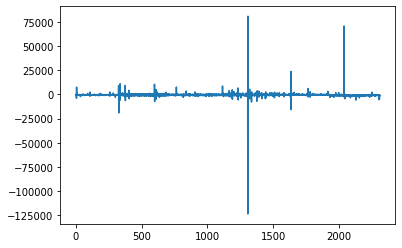

In [67]:
from BundleAdjustment import *
from scipy.optimize import least_squares
import time
camera_params = np.array(camera_params)
camera_indices = np.array(camera_indices)
print(len(points_3d))
point_indices = np.array(range(len(points_3d)))
points_3d = np.array(points_3d)
points_2d = np.array(points_2d)
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))
print(camera_params[0])
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
plt.plot(f0)
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))
#plt.plot(res.fun)
#fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d)

In [68]:
print(res)

 active_mask: array([0., 0., 0., ..., 0., 0., 0.])
        cost: 3.4617158667873353e-06
         fun: array([-1.02772901e-10, -4.16733315e-11,  9.97886218e-11, ...,
        9.34505806e-11, -5.15910870e-10,  7.61815500e-10])
        grad: array([ 3.82148697e-04, -7.37340181e-04,  5.42035919e-06, ...,
        2.34267681e-08, -5.17239134e-09, -3.37335492e-08])
         jac: <2310x3519 sparse matrix of type '<class 'numpy.float64'>'
	with 27720 stored elements in Compressed Sparse Row format>
     message: '`xtol` termination condition is satisfied.'
        nfev: 6632
        njev: 6206
  optimality: 1249572371.6655562
      status: 3
     success: True
           x: array([ 1.00507330e-03,  2.10903684e-03,  5.73718329e-03, ...,
        7.12606394e+00, -7.71061375e+00,  9.18205216e+00])


In [69]:
camera_params = res.x[:n_cameras * 9].reshape((n_cameras, 9))
points_3d = res.x[n_cameras * 9:].reshape((n_points, 3))

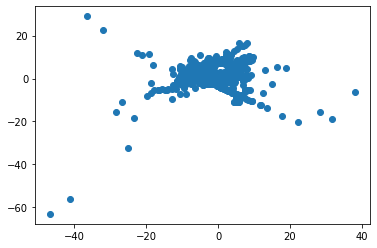

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0
1
2
3
4
5


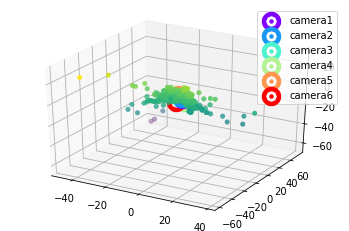

In [70]:
import matplotlib.cm as cm
#XZ
plt.scatter(points_3d[:,0], points_3d[:,2])
#plt.scatter(C0[0], C0[2], c='red')
#plt.scatter(C1[0], C1[2], c='black')
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], c=points_3d[:,2], cmap='viridis', linewidth=0.5);
colors = cm.rainbow(np.linspace(0, 1, len(C)))
for i,c in zip(C,colors):
    print(i)
    ax.scatter(C[i][0], C[i][1], C[i][2], c=c, linewidth=15, label='camera'+str(i+1));
ax.legend()
plt.show()

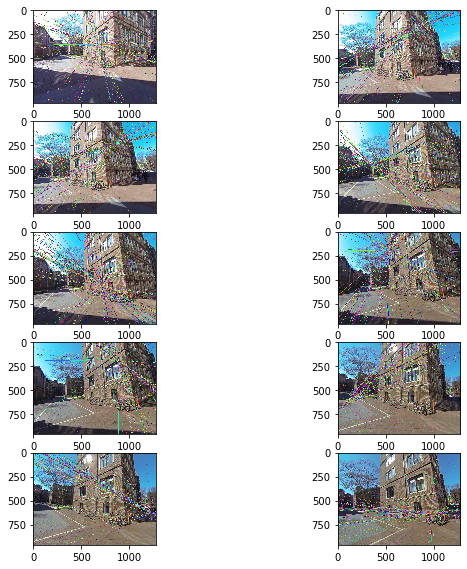

In [77]:
plt.figure(figsize=(10, 20))
for i, (left, right) in enumerate(lines_imgs):
    plt.subplot(len(lines_imgs*2),2,2*i+1)
    plt.imshow(left)
    plt.subplot(len(lines_imgs*2),2,2*i+2)
    plt.imshow(right)

In [32]:
print(len(points_3d))

188


In [33]:
print(points_3d[:10])

[[-0.3187459  -0.3310238   0.33156536]
 [-0.08428734 -0.03358754  0.22863093]
 [-0.01789879 -0.05107484  0.1381162 ]
 [-0.22486048 -0.1501568   0.34957483]
 [-0.15926502 -0.26235951  0.26331102]
 [-0.15901782 -0.05447135  0.23926028]
 [-0.33516513 -0.19645795  0.32066266]
 [-0.78933895 -0.35531952  1.01157898]
 [-0.14511327 -0.03382651  0.20812978]
 [-0.16542153 -0.12875184  0.271242  ]]
